In [9]:
%pip install -q --upgrade keras-cv
!pip install cleanvision


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import json
import sys
import os
import keras_cv
import cv2
from tensorflow.keras.preprocessing.image import save_img
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array, save_img

directory = "/kaggle/input/practical-innovative-analytics-data-science-2024/"
user_data = directory + "training_data"
test_data = directory + "label_book/" # this can be the label book, or any other test set you create

# Rules

- Submission must have less than 10,000 images combined in training and validation

**Submissions will be evaluated according to two categories:**
1. **Best Performance Overall**
2. **Most Innovative**

# 複製檔案+外部資料(已手動調整錯誤label)

In [11]:
import shutil

source_folder = '/kaggle/input/practical-innovative-analytics-data-science-2024/'
destination_folder = '/kaggle/working/original_data/'

#如果資料夾存在，刪除
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

# 複製資料夾
shutil.copytree(source_folder, destination_folder)
print(f"資料夾已成功從 {source_folder} 複製到 {destination_folder}")

#路徑設自己的
directory = "/kaggle/working/original_data/"
user_data = directory + "training_data"
test_data = directory + "label_book" # this can be the label book, or any other test set you create

資料夾已成功從 /kaggle/input/practical-innovative-analytics-data-science-2024/ 複製到 /kaggle/working/original_data/


In [12]:
## 複製訓練資料(訓練+驗證)
import shutil
# /kaggle/input/training-data-me/training_data
# /kaggle/input/training-data-add/training_data
source_folder = '/kaggle/input/data-plus/training_data'
destination_folder = '/kaggle/working/original_data/training_data'

#如果資料夾存在，刪除
if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)

# 複製資料夾
shutil.copytree(source_folder, destination_folder)
print(f"資料夾已成功從 {source_folder} 複製到 {destination_folder}")

#路徑設自己的
directory = "/kaggle/working/original_data/"
user_data = directory + "training_data"
test_data = directory + "label_book" # this can be the label book, or any other test set you create

資料夾已成功從 /kaggle/input/data-plus/training_data 複製到 /kaggle/working/original_data/training_data


#  資料清理

In [13]:
user_data + '/train'

'/kaggle/working/original_data/training_data/train'

In [14]:
tf.keras.backend.clear_session()
batch_size = 8
tf.random.set_seed(2024)

train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
    )

valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
)

Found 4043 files belonging to 10 classes.
Found 960 files belonging to 10 classes.


### cleanvision

In [15]:
from cleanvision.imagelab import Imagelab
imagelab_train = Imagelab(data_path=user_data + '/train')
# 檢測數據集中的問題
issues_train = imagelab_train.find_issues()
imagelab_train.issue_summary

Reading images from /kaggle/working/original_data/training_data/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4043 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4043 [00:00<?, ?it/s]

Issue checks completed. 8844 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,3988
1,grayscale,2756
2,light,1196
3,odd_size,822
4,near_duplicates,82
5,dark,0
6,odd_aspect_ratio,0
7,blurry,0
8,exact_duplicates,0


### 訓練集問題

* 低資訊:3988
* 過亮:1196
* 灰階:2756(不處理)
* 相似影像:82 

## 1. 重複影像刪除

In [16]:
imagelab_train.info['near_duplicates']['num_sets']

41

In [17]:
# 重複影像set
near_set = imagelab_train.info['near_duplicates']['sets']

In [18]:
for i in range(len(near_set)):
    file_path = near_set[i][0]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")


In [19]:
from cleanvision.imagelab import Imagelab
imagelab_train = Imagelab(data_path=user_data + '/train')
# 檢測數據集中的問題
issues_train = imagelab_train.find_issues()
imagelab_train.issue_summary

Reading images from /kaggle/working/original_data/training_data/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4002 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4002 [00:00<?, ?it/s]

Issue checks completed. 8671 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,3947
1,grayscale,2715
2,light,1187
3,odd_size,822
4,dark,0
5,blurry,0
6,odd_aspect_ratio,0
7,exact_duplicates,0
8,near_duplicates,0


## 2. 過亮(加雜訊)

In [20]:
# # 過亮影像數量
light_images = imagelab_train.issues[imagelab_train.issues["is_light_issue"] == True]
light_images_files = light_images.index.tolist()
print(len(light_images_files))
light_images_files[0]

1187


'/kaggle/working/original_data/training_data/train/i/1_cap_16.png'

In [21]:
## 方法2:噪聲+亮度
def add_gaussian_noise_and_adjust_brightness(image, mean=0.0, stddev=0.05, brightness_factor=0.7):
    """
    添加高斯噪聲並調整亮度
    :param image: 輸入影像的 NumPy 陣列
    :param mean: 高斯噪聲的平均值
    :param stddev: 高斯噪聲的標準差
    :param brightness_factor: 亮度調整因子
    :return: 添加噪聲並調整亮度後的影像
    """
    noise = tf.random.normal(shape=image.shape, mean=mean, stddev=stddev)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return tf.clip_by_value(noisy_image * brightness_factor, 0.0, 1.0)

for i, file_path in enumerate(light_images_files):
    try:
        image = load_img(file_path, target_size=(128, 128))
    except FileNotFoundError: 
        print(f"無檔案 {file_path}")
        pass
        
    
    image_array = img_to_array(image) / 255.0

    # 增強影像：結合高斯噪聲和亮度調整
    enhanced_image = add_gaussian_noise_and_adjust_brightness(image_array, mean=0.0, stddev=0.05, brightness_factor=0.8)

    # 提取檔案名稱
    base_name = os.path.basename(file_path)

    # 保存影像
    output_path = os.path.join(os.path.dirname(file_path), f"enhanced_n_{i}_{base_name}")
    save_img(output_path, enhanced_image)


In [22]:
from cleanvision.imagelab import Imagelab
imagelab_train = Imagelab(data_path=user_data + '/train')
# 檢測數據集中的問題
issues_train = imagelab_train.find_issues()
imagelab_train.issue_summary

Reading images from /kaggle/working/original_data/training_data/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5189 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5189 [00:00<?, ?it/s]

Issue checks completed. 9633 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,3947
1,grayscale,2715
2,light,1187
3,near_duplicates,962
4,odd_size,822
5,dark,0
6,odd_aspect_ratio,0
7,blurry,0
8,exact_duplicates,0


In [23]:
## 刪除過亮
light_images = imagelab_train.issues[imagelab_train.issues["is_light_issue"] == True]
light_images_files = light_images.index.tolist()
print(len(light_images_files))
print(light_images_files[0])

# 刪掉
for i in range(len(light_images_files)):
    file_path = light_images_files[i]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")


1187
/kaggle/working/original_data/training_data/train/i/1_cap_16.png


In [24]:
from cleanvision.imagelab import Imagelab
imagelab_train = Imagelab(data_path=user_data + '/train')
# 檢測數據集中的問題
issues_train = imagelab_train.find_issues()
imagelab_train.issue_summary

Reading images from /kaggle/working/original_data/training_data/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4002 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/4002 [00:00<?, ?it/s]

Issue checks completed. 5230 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,2760
1,grayscale,1826
2,odd_size,642
3,near_duplicates,2
4,dark,0
5,blurry,0
6,odd_aspect_ratio,0
7,light,0
8,exact_duplicates,0


In [25]:
# 重複影像set
near_set = imagelab_train.info['near_duplicates']['sets']
near_set
# 查看照片後覺得可以不用刪除

[['/kaggle/working/original_data/training_data/train/x/enhanced_n_1168_x_52.png',
  '/kaggle/working/original_data/training_data/train/x/x_144.png']]

### 處理過亮與相似後

* 低資訊:2760
* 灰階:1826

# 數據增強

In [26]:
# 列出全部影像路徑
from tensorflow.keras.utils import load_img, img_to_array, save_img

# 設定資料集目錄
dataset_dir = "/kaggle/working/original_data/training_data/train"  # 替換成你的數據集路徑

# 遍歷所有影像路徑並存入列表
all_image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # 過濾出常見影像格式
            all_image_files.append(os.path.join(root, file))

print(f"共找到 {len(all_image_files)} 張影像。")
print(f"第一張影像路徑: {all_image_files[0]}")  # 確認影像路徑是否正確



共找到 4002 張影像。
第一張影像路徑: /kaggle/working/original_data/training_data/train/ix/ix_354.png


In [27]:
import math
# 計算每張影像需要增強的次數
target_image_count = 9000
current_image_count = len(all_image_files)
augmentations_per_image = math.ceil(target_image_count / current_image_count)
print(f"每張影像需要增強 {augmentations_per_image-1} 次。")


每張影像需要增強 2 次。


In [28]:
# 增強
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),         
    tf.keras.layers.RandomZoom((0.2)),     # 縮小最多 20%，放大最多 20%
    tf.keras.layers.RandomTranslation(0.15, 0.15),# 高度和寬度各平移 ±15%
    tf.keras.layers.RandomContrast([0.1, 0.2]),          
    tf.keras.layers.Resizing(128, 128),           # 統一調整影像大小
])

# 處理每張影像
augmented_count = 0  # 記錄已增強影像數量

for file_path in all_image_files:
    for a in range(2):  # 為每張影像執行多次增強
        # 加載影像
        image = load_img(file_path, target_size=(128, 128))  # 可調整影像大小
        image_array = img_to_array(image) / 255.0  # 正規化到 [0, 1]

        # 增強影像
        enhanced_image = data_augmentation(image_array[None, ...], training=True)[0].numpy()
        enhanced_image = tf.clip_by_value(enhanced_image, 0.0, 1.0)  # 確保像素值在範圍內

        # 設定保存路徑
        original_dir = os.path.dirname(file_path)  # 原始影像目錄
        base_name = os.path.basename(file_path)   # 原始影像檔名
        output_path = os.path.join(original_dir, f"aug_{augmented_count}_{base_name}")  # 新檔名帶上索引值

        # 保存增強影像
        save_img(output_path, enhanced_image)
        augmented_count += 1

        # 打印進度
        if augmented_count % 500 == 0:
            print(f"已保存 {augmented_count} 張增強影像。")

        # 如果達到目標數量，則提前結束
        if augmented_count >= target_image_count - current_image_count:
            break

print(f"增強完成，共生成 {augmented_count} 張增強影像，總數為 {current_image_count + augmented_count} 張。")


已保存 500 張增強影像。
已保存 1000 張增強影像。
已保存 1500 張增強影像。
已保存 2000 張增強影像。
已保存 2500 張增強影像。
已保存 3000 張增強影像。
已保存 3500 張增強影像。
已保存 4000 張增強影像。
已保存 4500 張增強影像。
已保存 5000 張增強影像。
已保存 5500 張增強影像。
已保存 6000 張增強影像。
已保存 6500 張增強影像。
增強完成，共生成 6501 張增強影像，總數為 10503 張。


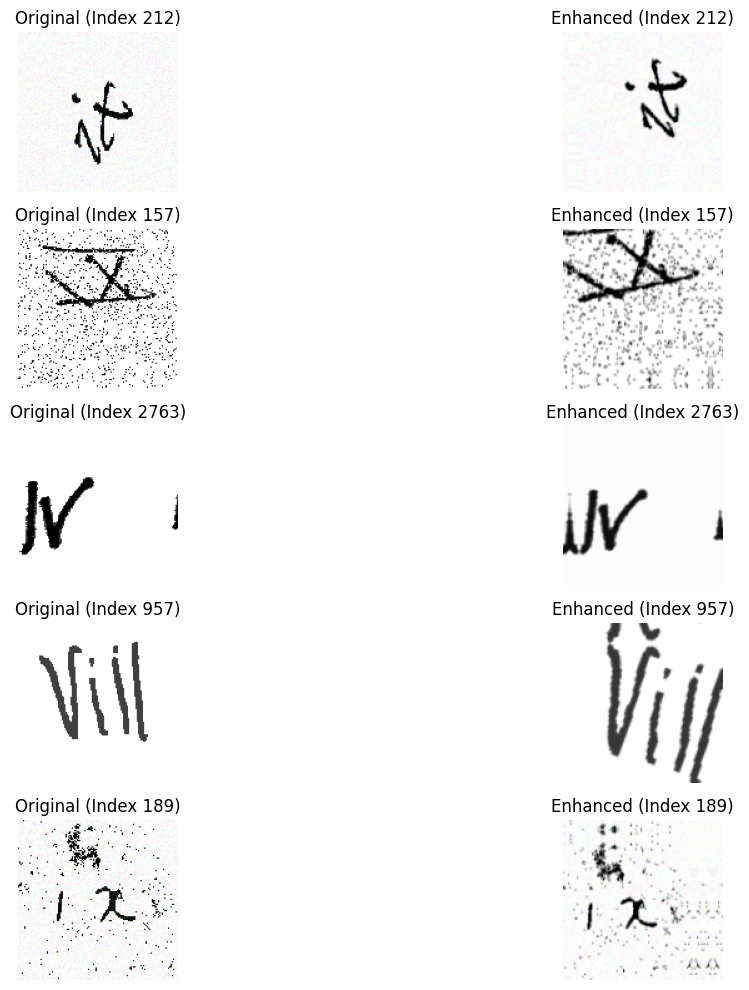

In [29]:
import random
plt.figure(figsize=(15, 10))  # 調整畫布大小

# 確保隨機選取的影像不重複
random_indices = random.sample(range(len(all_image_files)), 5)

for i, idx in enumerate(random_indices):  # 隨機挑選 5 張圖片
    original_image = img_to_array(load_img(all_image_files[idx], target_size=(128, 128))) / 255.0
    augmented_image = data_augmentation(original_image[None, ...], training=True)[0].numpy()
    
    # 左邊顯示原圖
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title(f"Original (Index {idx})")
    plt.axis("off")
    
    # 右邊顯示增強圖
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(augmented_image)
    plt.title(f"Enhanced (Index {idx})")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 檢測增強後的數據問題

In [30]:
from cleanvision.imagelab import Imagelab
imagelab_train_final = Imagelab(data_path=user_data + '/train')
# 檢測數據集中的問題
issues_train = imagelab_train_final.find_issues()
imagelab_train_final.issue_summary

Reading images from /kaggle/working/original_data/training_data/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10503 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10503 [00:00<?, ?it/s]

Issue checks completed. 7194 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,4151
1,grayscale,1826
2,odd_size,855
3,light,354
4,near_duplicates,8
5,dark,0
6,odd_aspect_ratio,0
7,blurry,0
8,exact_duplicates,0


## 圖片相似問題

In [31]:
near_set = imagelab_train_final.info['near_duplicates']['sets']
for i in range(len(near_set)):
    file_path = near_set[i][0]
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")

檔案 /kaggle/working/original_data/training_data/train/i/aug_2703_enhanced_n_70_i_17.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/train/i/aug_3236_enhanced_n_119_i_26.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/train/v/enhanced_n_767_v_323.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/train/x/enhanced_n_1168_x_52.png 已成功刪除。


## 過量影像刪除

In [32]:
# # 過亮影像數量
light_images = imagelab_train_final.issues[imagelab_train_final.issues["is_light_issue"] == True]
light_images_files = light_images.index.tolist()
print(len(light_images_files))
# light_images_files[0]
## 方法2:噪聲+亮度
for i, file_path in enumerate(light_images_files):
    try:
        image = load_img(file_path, target_size=(128, 128))
    except FileNotFoundError: 
        print(f"無檔案 {file_path}")
        pass
    image_array = img_to_array(image) / 255.0

    # 增強影像：結合高斯噪聲和亮度調整
    enhanced_image = add_gaussian_noise_and_adjust_brightness(image_array, mean=0.0, stddev=0.05, brightness_factor=0.8)

    # 提取檔案名稱
    base_name = os.path.basename(file_path)

    # 保存影像
    output_path = os.path.join(os.path.dirname(file_path), f"enhanced_n_{i}_{base_name}")
    save_img(output_path, enhanced_image)

# 刪掉
for i in range(len(light_images_files)):
    file_path = light_images_files[i]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")

354
無檔案 /kaggle/working/original_data/training_data/train/i/aug_2703_enhanced_n_70_i_17.png
無檔案 /kaggle/working/original_data/training_data/train/i/aug_3236_enhanced_n_119_i_26.png
檔案 /kaggle/working/original_data/training_data/train/i/aug_2703_enhanced_n_70_i_17.png 不存在，無需刪除。
檔案 /kaggle/working/original_data/training_data/train/i/aug_3236_enhanced_n_119_i_26.png 不存在，無需刪除。


In [33]:
from cleanvision.imagelab import Imagelab
imagelab_train_final = Imagelab(data_path=user_data + '/train')
# 檢測數據集中的問題
issues_train = imagelab_train_final.find_issues()
imagelab_train_final.issue_summary

Reading images from /kaggle/working/original_data/training_data/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10501 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/10501 [00:00<?, ?it/s]

Issue checks completed. 6822 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,4145
1,grayscale,1826
2,odd_size,845
3,near_duplicates,6
4,dark,0
5,blurry,0
6,odd_aspect_ratio,0
7,light,0
8,exact_duplicates,0


In [34]:
near_set = imagelab_train_final.info['near_duplicates']['sets']
for i in range(len(near_set)):
    file_path = near_set[i][0]
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")

檔案 /kaggle/working/original_data/training_data/train/i/enhanced_n_161_aug_3229_i_115.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/train/ii/enhanced_n_305_ii_251.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/train/x/enhanced_n_1130_x_247.png 已成功刪除。


## 刪除部分低資訊

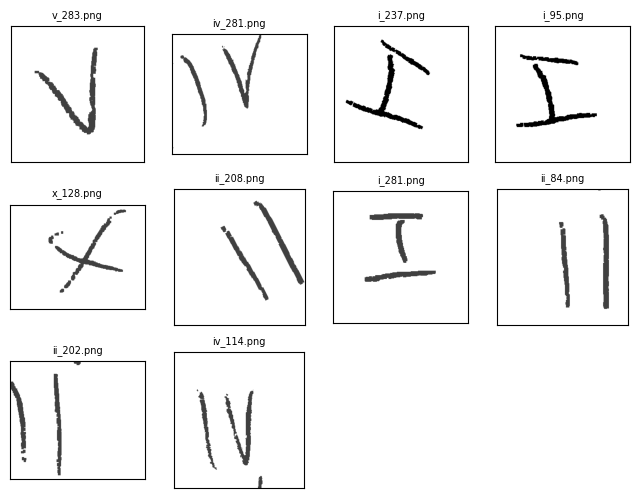

In [35]:
f_low_information_images = imagelab_train_final.issues[imagelab_train_final.issues["is_low_information_issue"] == True].sort_values(by=['low_information_score'], ascending=True)
f_low_information_image_files = f_low_information_images.index.tolist()
imagelab_train_final.visualize(image_files=f_low_information_image_files[:10])
#print(f_low_information_images.head())


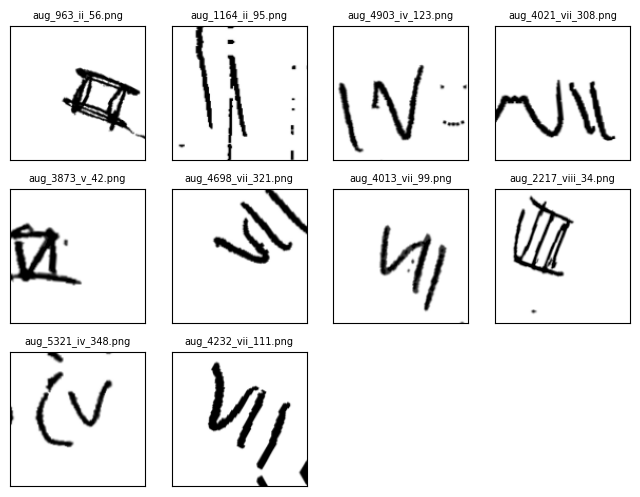

In [36]:
f_low_information_images = imagelab_train_final.issues[imagelab_train_final.issues["is_low_information_issue"] == True].sort_values(by=['low_information_score'], ascending=False)
f_low_information_image_files = f_low_information_images.index.tolist()
imagelab_train_final.visualize(image_files=f_low_information_image_files[:10])
#print(f_low_information_images.head())


In [37]:
# 設定資料集目錄
dataset_dir = "/kaggle/working/original_data/training_data/train"  # 替換成你的數據集路徑

# 遍歷所有影像路徑並存入列表
all_image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # 過濾出常見影像格式
            all_image_files.append(os.path.join(root, file))

print(f"共找到 {len(all_image_files)} 張影像。")
print(f"第一張影像路徑: {all_image_files[0]}")  # 確認影像路徑是否正確

共找到 10498 張影像。
第一張影像路徑: /kaggle/working/original_data/training_data/train/ix/aug_589_ix_289.png


In [38]:
current_image_count = len(all_image_files)

In [39]:
num = current_image_count - 9000
num

1498

In [40]:
# 刪除低資訊,讓訓練集剩下9000
# 將 low_information_score < 0.2 的圖像檔名提取到列表
low_score_images = f_low_information_images[f_low_information_images["low_information_score"] < 0.3]
low_score_image_files = low_score_images.index.tolist()
# list(low_score_image_files)
# 打印結果
print(len(low_score_image_files))
# 刪掉500張低資訊照片
for i in range(num):
    file_path = low_score_image_files[i]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    # else:
        # print(f"檔案 {file_path} 不存在，無需刪除。")

4145


In [41]:
from cleanvision.imagelab import Imagelab
imagelab_train_final = Imagelab(data_path=user_data + '/train')
# 檢測數據集中的問題
issues_train = imagelab_train_final.find_issues()
imagelab_train_final.issue_summary

Reading images from /kaggle/working/original_data/training_data/train
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/9000 [00:00<?, ?it/s]

Issue checks completed. 4924 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,2647
1,grayscale,1797
2,odd_size,480
3,dark,0
4,light,0
5,blurry,0
6,odd_aspect_ratio,0
7,exact_duplicates,0
8,near_duplicates,0


In [42]:
tf.keras.backend.clear_session()
batch_size = 1
tf.random.set_seed(2024)

train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
    )

valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
)

Found 9000 files belonging to 10 classes.
Found 960 files belonging to 10 classes.


# 處理驗證集

#### 驗證集問題

In [43]:
from cleanvision.imagelab import Imagelab
imagelab_val = Imagelab(data_path=user_data + '/val')
# 檢測數據集中的問題
issues_val = imagelab_val.find_issues()
imagelab_val.issue_summary

Reading images from /kaggle/working/original_data/training_data/val
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/960 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/960 [00:00<?, ?it/s]

Issue checks completed. 2499 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,959
1,grayscale,893
2,light,620
3,near_duplicates,22
4,odd_size,5
5,dark,0
6,odd_aspect_ratio,0
7,blurry,0
8,exact_duplicates,0


## 刪除重複影像

In [44]:
imagelab_val.info['near_duplicates']['num_sets']

11

In [45]:
# 重複影像set
near_set = imagelab_val.info['near_duplicates']['sets']

In [46]:
for i in range(len(near_set)):
    file_path = near_set[i][0]
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")

檔案 /kaggle/working/original_data/training_data/val/ii/ii_0.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/ii/ii_18.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/iii/ii_93.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/iii/iii_5.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/iv/iv_0.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/ix/iii_77.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/vii/vii_26.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/vii/vii_4.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/viii/viii_0.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/x/v_43.png 已成功刪除。
檔案 /kaggle/working/original_data/training_data/val/x/x_2.png 已成功刪除。


In [47]:
from cleanvision.imagelab import Imagelab
imagelab_val = Imagelab(data_path=user_data + '/val')
# 檢測數據集中的問題
issues_val = imagelab_val.find_issues()
imagelab_val.issue_summary

Reading images from /kaggle/working/original_data/training_data/val
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/949 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/949 [00:00<?, ?it/s]

Issue checks completed. 2452 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,948
1,grayscale,882
2,light,617
3,odd_size,5
4,dark,0
5,blurry,0
6,odd_aspect_ratio,0
7,exact_duplicates,0
8,near_duplicates,0


## 處理過亮

In [48]:
# # 過亮影像數量
light_images = imagelab_val.issues[imagelab_val.issues["is_light_issue"] == True]
vlight_images_files = light_images.index.tolist()
print(len(vlight_images_files))
vlight_images_files[0]

617


'/kaggle/working/original_data/training_data/val/i/i_0.png'

In [49]:
## 方法2:噪聲+亮度
def add_gaussian_noise_and_adjust_brightness(image, mean=0.0, stddev=0.05, brightness_factor=0.7):
    """
    添加高斯噪聲並調整亮度
    :param image: 輸入影像的 NumPy 陣列
    :param mean: 高斯噪聲的平均值
    :param stddev: 高斯噪聲的標準差
    :param brightness_factor: 亮度調整因子
    :return: 添加噪聲並調整亮度後的影像
    """
    noise = tf.random.normal(shape=image.shape, mean=mean, stddev=stddev)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return tf.clip_by_value(noisy_image * brightness_factor, 0.0, 1.0)

for i, file_path in enumerate(vlight_images_files):
    try:
        image = load_img(file_path, target_size=(128, 128))
    except FileNotFoundError: 
        print(f"無檔案 {file_path}")
        pass
    
    image_array = img_to_array(image) / 255.0

    # 增強影像：結合高斯噪聲和亮度調整
    enhanced_image = add_gaussian_noise_and_adjust_brightness(image_array, mean=0.0, stddev=0.05, brightness_factor=0.8)

    # 提取檔案名稱
    base_name = os.path.basename(file_path)

    # 保存影像
    output_path = os.path.join(os.path.dirname(file_path), f"enhanced_n_{i}_{base_name}")
    save_img(output_path, enhanced_image)


In [50]:
## 刪除過亮
vlight_images = imagelab_val.issues[imagelab_val.issues["is_light_issue"] == True]
vlight_images_files = vlight_images.index.tolist()
print(len(vlight_images_files))
vlight_images_files[0]
# 刪掉
for i in range(len(vlight_images_files)):
    file_path = vlight_images_files[i]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")


617


In [51]:
from cleanvision.imagelab import Imagelab
imagelab_val = Imagelab(data_path=user_data + '/val')
# 檢測數據集中的問題
issues_val = imagelab_val.find_issues()
imagelab_val.issue_summary

Reading images from /kaggle/working/original_data/training_data/val
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/949 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/949 [00:00<?, ?it/s]

Issue checks completed. 633 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,331
1,grayscale,300
2,near_duplicates,2
3,dark,0
4,light,0
5,blurry,0
6,odd_aspect_ratio,0
7,odd_size,0
8,exact_duplicates,0


## 數據增強後加入驗證集

In [52]:
# 列出全部影像路徑
from tensorflow.keras.utils import load_img, img_to_array, save_img

# 設定資料集目錄
dataset_dir = "/kaggle/working/original_data/training_data/val"  # 替換成你的數據集路徑

# 遍歷所有影像路徑並存入列表
all_image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # 過濾出常見影像格式
            all_image_files.append(os.path.join(root, file))

print(f"共找到 {len(all_image_files)} 張影像。")
print(f"第一張影像路徑: {all_image_files[0]}")  # 確認影像路徑是否正確

共找到 949 張影像。
第一張影像路徑: /kaggle/working/original_data/training_data/val/ix/enhanced_n_256_ix_15.png


In [53]:
import math
# 計算每張影像需要增強的次數
target_image_count = 3000
current_image_count = len(all_image_files)
augmentations_per_image = math.ceil(target_image_count / current_image_count)
print(f"每張影像需要增強 {augmentations_per_image-1} 次。")


每張影像需要增強 3 次。


In [54]:
# 增強
#data_augmentation = tf.keras.Sequential([
    #tf.keras.layers.RandomRotation(0.05),
    #tf.keras.layers.RandomZoom((0.1)),
    #tf.keras.layers.RandomTranslation(0.1, 0.1),
    #tf.keras.layers.RandomContrast([0.1, 0.2]),
    #tf.keras.layers.Resizing(128, 128),
#])


In [55]:
# 增強
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom((0.1)),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast([0.05, 0.1]),
    tf.keras.layers.Resizing(128, 128),
])

# 處理每張影像
augmented_count = 0  # 記錄已增強影像數量

for file_path in all_image_files:
    for a in range(3):  # 為每張影像執行多次增強
        # 加載影像
        image = load_img(file_path, target_size=(128, 128))  # 可調整影像大小
        image_array = img_to_array(image) / 255.0  # 正規化到 [0, 1]

        # 增強影像
        enhanced_image = data_augmentation(image_array[None, ...], training=True)[0].numpy()
        enhanced_image = tf.clip_by_value(enhanced_image, 0.0, 1.0)  # 確保像素值在範圍內

        # 設定保存路徑
        original_dir = os.path.dirname(file_path)  # 原始影像目錄
        base_name = os.path.basename(file_path)   # 原始影像檔名
        output_path = os.path.join(original_dir, f"aug_{augmented_count}_{base_name}")  # 新檔名帶上索引值

        # 保存增強影像
        save_img(output_path, enhanced_image)
        augmented_count += 1

        # 打印進度
        if augmented_count % 500 == 0:
            print(f"已保存 {augmented_count} 張增強影像。")

        # 如果達到目標數量，則提前結束
        if augmented_count >= target_image_count - current_image_count:
            break

print(f"增強完成，共生成 {augmented_count} 張增強影像，總數為 {current_image_count + augmented_count} 張。")


已保存 500 張增強影像。
已保存 1000 張增強影像。
已保存 1500 張增強影像。
已保存 2000 張增強影像。
增強完成，共生成 2316 張增強影像，總數為 3265 張。


In [56]:
tf.keras.backend.clear_session()
batch_size = 1
tf.random.set_seed(2024)

train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
    )

valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
)

Found 9000 files belonging to 10 classes.
Found 3265 files belonging to 10 classes.


## 看增強後的數據問題

In [57]:
from cleanvision.imagelab import Imagelab
imagelab_val_final = Imagelab(data_path=user_data + '/val')
# 檢測數據集中的問題
issues_val = imagelab_val_final.find_issues()
imagelab_val_final.issue_summary

Reading images from /kaggle/working/original_data/training_data/val
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3265 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3265 [00:00<?, ?it/s]

Issue checks completed. 2010 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,861
1,light,495
2,odd_size,332
3,grayscale,300
4,near_duplicates,22
5,dark,0
6,odd_aspect_ratio,0
7,blurry,0
8,exact_duplicates,0


In [58]:
# # 過亮影像數量
light_images = imagelab_val_final.issues[imagelab_val_final.issues["is_light_issue"] == True]
vlight_images_files = light_images.index.tolist()
print(len(vlight_images_files))
vlight_images_files[0]

495


'/kaggle/working/original_data/training_data/val/i/aug_1000_enhanced_n_69_i_92.png'

In [59]:
## 方法2:噪聲+亮度
for i, file_path in enumerate(vlight_images_files):
    image = load_img(file_path, target_size=(128, 128))
    image_array = img_to_array(image) / 255.0

    # 增強影像：結合高斯噪聲和亮度調整
    enhanced_image = add_gaussian_noise_and_adjust_brightness(image_array, mean=0.0, stddev=0.05, brightness_factor=0.8)

    # 提取檔案名稱
    base_name = os.path.basename(file_path)

    # 保存影像
    output_path = os.path.join(os.path.dirname(file_path), f"enhanced_n_{i}_{base_name}")
    save_img(output_path, enhanced_image)


In [60]:
## 刪除過亮
vlight_images = imagelab_val_final.issues[imagelab_val_final.issues["is_light_issue"] == True]
vlight_images_files = vlight_images.index.tolist()
print(len(vlight_images_files))
vlight_images_files[0]
# 刪掉
for i in range(len(vlight_images_files)):
    file_path = vlight_images_files[i]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")

495


In [61]:
near_set = imagelab_val_final.info['near_duplicates']['sets']
for i in range(len(near_set)):
    file_path = near_set[i][0]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    else:
        print(f"檔案 {file_path} 不存在，無需刪除。")

檔案 /kaggle/working/original_data/training_data/val/i/aug_1008_enhanced_n_14_i_24.png 不存在，無需刪除。
檔案 /kaggle/working/original_data/training_data/val/i/aug_1010_enhanced_n_14_i_24.png 不存在，無需刪除。
檔案 /kaggle/working/original_data/training_data/val/i/aug_1037_enhanced_n_36_i_52.png 不存在，無需刪除。
檔案 /kaggle/working/original_data/training_data/val/i/aug_858_enhanced_n_60_i_81.png 不存在，無需刪除。
檔案 /kaggle/working/original_data/training_data/val/ii/aug_454_enhanced_n_134_ii_9.png 不存在，無需刪除。
檔案 /kaggle/working/original_data/training_data/val/iv/aug_1839_enhanced_n_197_iv_4.png 不存在，無需刪除。
檔案 /kaggle/working/original_data/training_data/val/iv/aug_1924_enhanced_n_242_v_31.png 不存在，無需刪除。


In [62]:
from cleanvision.imagelab import Imagelab
imagelab_val_final = Imagelab(data_path=user_data + '/val')
# 檢測數據集中的問題
issues_val = imagelab_val_final.find_issues()
imagelab_val_final.issue_summary

Reading images from /kaggle/working/original_data/training_data/val
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3261 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/3261 [00:00<?, ?it/s]

Issue checks completed. 1508 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,860
1,odd_size,332
2,grayscale,300
3,near_duplicates,16
4,dark,0
5,blurry,0
6,odd_aspect_ratio,0
7,light,0
8,exact_duplicates,0


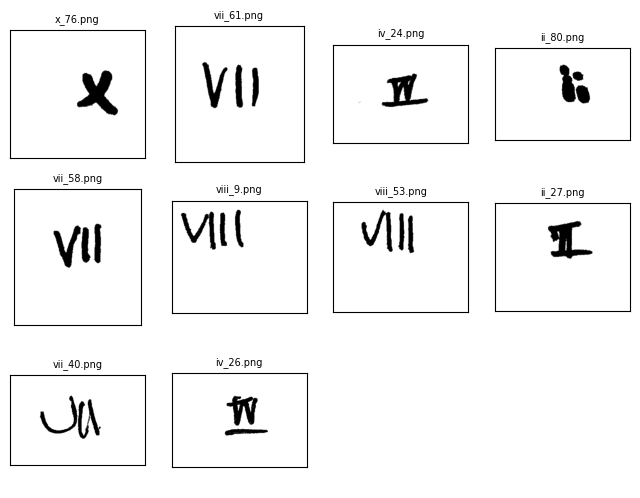

In [63]:
f_low_information_images = imagelab_val_final.issues[imagelab_val_final.issues["is_low_information_issue"] == True].sort_values(by=['low_information_score'], ascending=True)
f_low_information_image_files = f_low_information_images.index.tolist()
imagelab_val_final.visualize(image_files=f_low_information_image_files[:10])
#print(f_low_information_images.head())

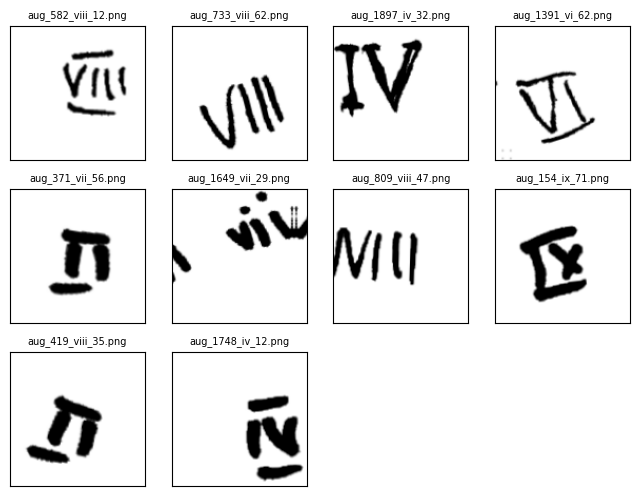

In [64]:
f_low_information_images = imagelab_val_final.issues[imagelab_val_final.issues["is_low_information_issue"] == True].sort_values(by=['low_information_score'], ascending=False)
f_low_information_image_files = f_low_information_images.index.tolist()
imagelab_val_final.visualize(image_files=f_low_information_image_files[:10])
#print(f_low_information_images.head())


In [65]:
# 設定資料集目錄
dataset_dir = "/kaggle/working/original_data/training_data/val"  # 替換成你的數據集路徑

# 遍歷所有影像路徑並存入列表
all_image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # 過濾出常見影像格式
            all_image_files.append(os.path.join(root, file))

print(f"共找到 {len(all_image_files)} 張影像。")
print(f"第一張影像路徑: {all_image_files[0]}")  # 確認影像路徑是否正確

共找到 3261 張影像。
第一張影像路徑: /kaggle/working/original_data/training_data/val/ix/enhanced_n_256_ix_15.png


In [66]:
current_image_count = len(all_image_files)

In [67]:
num = current_image_count - 2940
num

321

In [68]:
# 刪除低資訊,讓驗證集剩下2900
# 將 low_information_score < 0.2 的圖像檔名提取到列表
low_score_images = f_low_information_images[f_low_information_images["low_information_score"] < 0.3]
low_score_image_files = low_score_images.index.tolist()
# list(low_score_image_files)
# 打印結果
print(len(low_score_image_files))
# 刪掉500張低資訊照片
for i in range(num):
    file_path = low_score_image_files[i]
    if os.path.exists(file_path):
        os.remove(file_path)
        # print(f"檔案 {file_path} 已成功刪除。")
    # else:
        # print(f"檔案 {file_path} 不存在，無需刪除。")

860


In [69]:
low_score_images_df = low_score_images[['low_information_score']].reset_index()
#print(low_score_images_df.head())
print(low_score_images_df.iloc[0]["index"])

/kaggle/working/original_data/training_data/val/viii/aug_582_viii_12.png


In [70]:
from cleanvision.imagelab import Imagelab
imagelab_val_final = Imagelab(data_path=user_data + '/val')
# 檢測數據集中的問題
issues_val = imagelab_val_final.find_issues()
imagelab_val_final.issue_summary

Reading images from /kaggle/working/original_data/training_data/val
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2940 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/2940 [00:00<?, ?it/s]

Issue checks completed. 1181 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


,issue_type,num_images
0,low_information,539
1,odd_size,328
2,grayscale,298
3,near_duplicates,16
4,dark,0
5,blurry,0
6,odd_aspect_ratio,0
7,light,0
8,exact_duplicates,0


### 檢查輸入照片數

In [71]:
tf.keras.backend.clear_session()
batch_size = 1
tf.random.set_seed(2024)

train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
    )

valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(128, 128),
)

Found 9000 files belonging to 10 classes.
Found 2940 files belonging to 10 classes.


# Getting started


The dataset contains ~4400 images of handwritten roman numerals 1-10. **Your task is to optimize model performance by improving the dataset and making training and validation splits.**

You can try fixing incorrect labels, adding data for side case tuning, apply data augmentation techniques, or use any other method to improve the data. You may also find it helpful to take a look at the training script to get a better sense of the model below (these are held fixed). The script will resize all images to `(32, 32)` and run them through a cut off version of ResNet50. 

In [72]:
### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
tf.keras.backend.clear_session()
batch_size = 8
tf.random.set_seed(2024)

train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
)

total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()

if total_length > 12_000:
    print(f"Dataset size larger than 12,000. Got {total_length} examples")
    sys.exit()

test = tf.keras.preprocessing.image_dataset_from_directory(
        test_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=False,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
)

# Initialize the base model using KerasCV's ResNet50
backbone = keras_cv.models.ResNet50Backbone.from_preset(
    input_shape=(32, 32, 3),
    preset = "resnet50_imagenet",
    load_weights=False,
)

# Create a new model that outputs the desired intermediate layer
base_model = tf.keras.Model(
    inputs=backbone.inputs,
    outputs=backbone.get_layer("v2_stack_0_block3_out").output
)

# Define the input tensor
inputs = tf.keras.Input(shape=(32, 32, 3))

# Pass the preprocessed input through the base model
x = base_model(inputs)

# Add global average pooling
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dense layer for classification (assuming 10 classes)
x = tf.keras.layers.Dense(10)(x)

# Define the final model
model = tf.keras.Model(inputs, x)

# Compile the model with appropriate optimizer, loss, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Display the model's architecture
model.summary()
    
loss_0, acc_0 = model.evaluate(valid)
print(f"loss {loss_0}, acc {acc_0}")

checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model.weights.h5",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1, min_lr=1e-7)

history = model.fit(
        train,
        validation_data=valid,
        epochs=75,
        callbacks=[checkpoint, lr_scheduler],
)

model.load_weights("best_model.weights.h5")

loss, acc = model.evaluate(valid)
print(f"final loss {loss}, final acc {acc}")

test_loss, test_acc = model.evaluate(test)
print(f"test loss {test_loss}, test acc {test_acc}")

### DO NOT MODIFY ABOVE THIS LINE, THIS IS THE FIXED MODEL ###

Found 9000 files belonging to 10 classes.
Found 2940 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 8, 8, 256)      │       228,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,858 (901.79 KB)

 Trainable params: 227,914 (890.29 KB)

 Non-trainable params: 2,944 (11.50 KB)

I0000 00:00:1734255979.223830    8488 service.cc:145] XLA service 0x5d09982307a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734255979.223891    8488 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734255979.223897    8488 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 55/368 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1299 - loss: 2.3122

I0000 00:00:1734255980.204205    8488 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1235 - loss: 2.3081
loss 2.3049495220184326, acc 0.1210884377360344
Epoch 1/75
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.2636 - loss: 2.2117 - val_accuracy: 0.4092 - val_loss: 1.7176 - learning_rate: 1.0000e-04
Epoch 2/75
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4661 - loss: 1.5125 - val_accuracy: 0.6136 - val_loss: 1.2351 - learning_rate: 1.0000e-04
Epoch 3/75
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5982 - loss: 1.1898 - val_accuracy: 0.4252 - val_loss: 1.5639 - learning_rate: 1.0000e-04
Epoch 4/75
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6753 - loss: 1.0003 - val_accuracy: 0.5221 - val_loss: 1.2526 - learning_rate: 1.0000e-04
Epoch 5/75
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7126 - loss: 0.8640 - val_accuracy: 0.7007 - val_loss: 0.8690 - learning_rate: 1.0000e-04
Epoch 6/75
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7553 - loss: 0.770

## Make your submission

Remember that the evaluation metric is Macro F1 score, you may want to also evaluate the above results using the Macro F1 score before submission.

In [73]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory+"testing_data",
    shuffle = False,
    image_size=(32, 32),
    batch_size=1)

prob = model.predict(test_dataset)
predictions = []
for i in range(0, prob.shape[0]):
    predictions.append(np.argmax(prob[i,:])+1)

Found 500 files belonging to 1 classes.
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [74]:
import pandas as pd

paths = test_dataset.file_paths

Ids = []
for x in paths:
    Ids.append(x.split("/")[-1])
    
df = pd.DataFrame()
df["Id"] = Ids
df["Predicted"] = predictions
df.to_csv("submission.csv", index=False)

In [75]:
#!zip -r /kaggle/working/original_data.zip /kaggle/working/original_data